In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN


2023-11-06 20:36:59.806587: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 20:36:59.965607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 20:36:59.965641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 20:36:59.966267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 20:37:00.035267: I tensorflow/core/platform/cpu_feature_g

In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [17]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping

2023-11-06 20:37:02.203642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:37:02.308014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:37:02.308060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:37:02.311427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:37:02.311458: I tensorflow/compile

Epoch 1/1000


2023-11-06 20:37:03.824496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-06 20:37:03.980077: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 20:37:04.170079: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 20:37:04.475969: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xaca8940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 20:37:04.475996: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-06 20:37:04.478852: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 20:37:04.528413: I ./tensorflow/compiler/jit/device_compil

4/4 [==============================] - 3s 166ms/step - loss: 12.9864 - val_loss: 5.0747
Epoch 2/1000
4/4 [==============================] - 0s 16ms/step - loss: 3.5663 - val_loss: 0.0437
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5066 - val_loss: 0.4729
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1236 - val_loss: 0.2232
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2566 - val_loss: 0.0137
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0465 - val_loss: 0.0812
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0318 - val_loss: 0.0352
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0431 - val_loss: 0.0186
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0113
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0144 - val_loss: 0.0097
Epoch 11/1000
4/4 [=

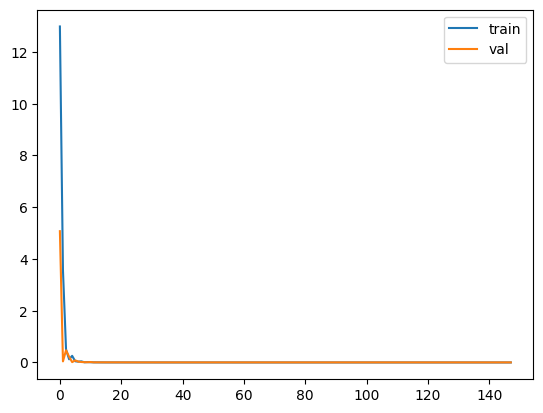

4/4 [==============================] - 0s 24ms/step
mae: 2.3912936483415876
(126,)
(126,)


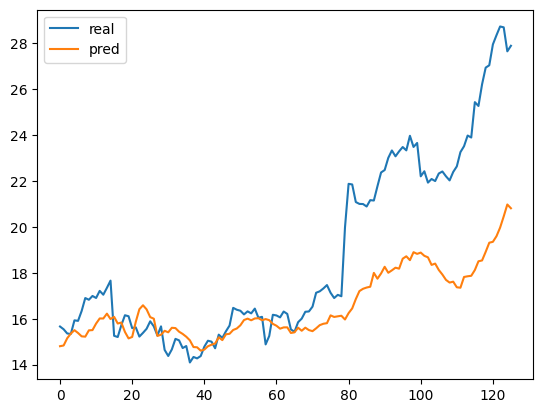

Epoch 1/1000
7/7 [==============================] - 2s 90ms/step - loss: 14.4770 - val_loss: 0.1339
Epoch 2/1000
7/7 [==============================] - 0s 10ms/step - loss: 1.1348 - val_loss: 0.5831
Epoch 3/1000
7/7 [==============================] - 0s 12ms/step - loss: 1.1462 - val_loss: 0.9833
Epoch 4/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1752 - val_loss: 0.0642
Epoch 5/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1340 - val_loss: 0.1862
Epoch 6/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0443 - val_loss: 0.0109
Epoch 7/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0333 - val_loss: 0.0497
Epoch 8/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 9/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0161
Epoch 10/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0170
Epoch 11

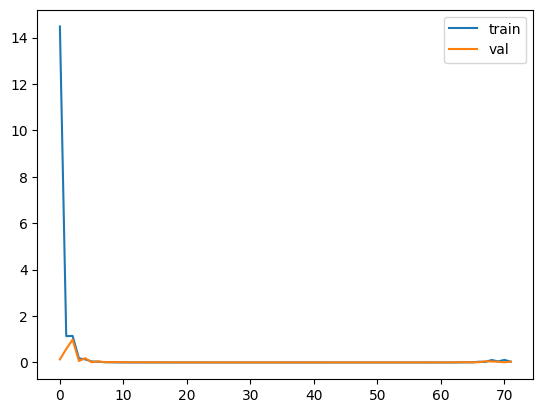

4/4 [==============================] - 0s 3ms/step
mae: 5.849528967996263
(126,)
(126,)


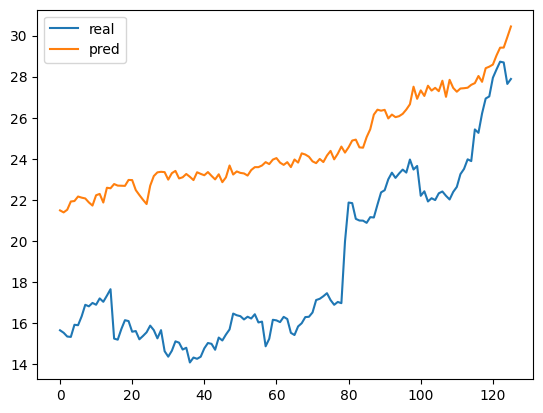

Epoch 1/1000
10/10 [==============================] - 2s 76ms/step - loss: 7.1323 - val_loss: 0.0148
Epoch 2/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.3707 - val_loss: 1.5557
Epoch 3/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.5319 - val_loss: 0.0827
Epoch 4/1000
10/10 [==============================] - 0s 10ms/step - loss: 1.3072 - val_loss: 0.0762
Epoch 5/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.1725 - val_loss: 0.0649
Epoch 6/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0620 - val_loss: 0.0057
Epoch 7/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0299 - val_loss: 0.0027
Epoch 8/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0101 - val_loss: 0.0156
Epoch 9/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 10/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 

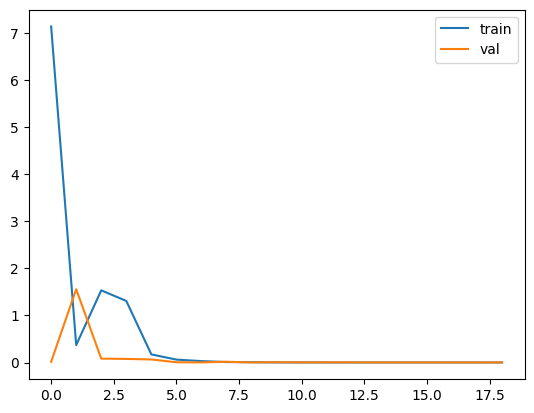

4/4 [==============================] - 0s 3ms/step
mae: 5.7551247461988675
(126,)
(126,)


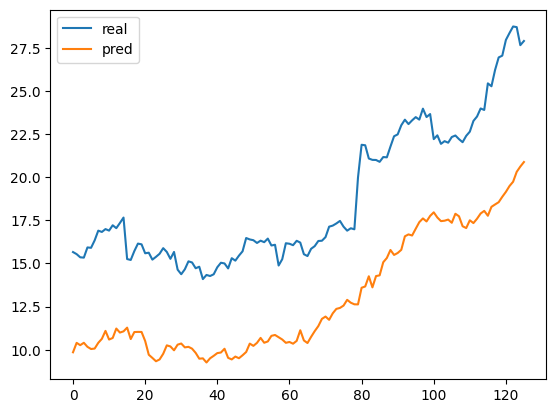

Epoch 1/1000
13/13 [==============================] - 2s 54ms/step - loss: 6.2695 - val_loss: 0.1883
Epoch 2/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.2268 - val_loss: 0.4136
Epoch 3/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.2587 - val_loss: 0.2583
Epoch 4/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.2411 - val_loss: 0.0750
Epoch 5/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.5267 - val_loss: 0.0502
Epoch 6/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0578 - val_loss: 0.0011
Epoch 7/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0288 - val_loss: 0.0053
Epoch 8/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0172 - val_loss: 0.0017
Epoch 9/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0220 - val_loss: 0.0147
Epoch 10/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0249 - val_loss: 

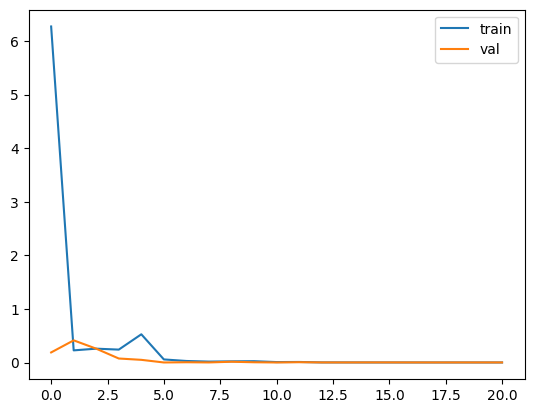

4/4 [==============================] - 0s 2ms/step
mae: 0.8329385558621847
(126,)
(126,)


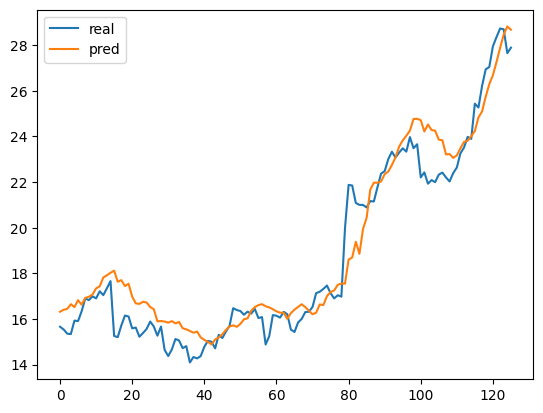

Epoch 1/1000
17/17 [==============================] - 2s 35ms/step - loss: 4.1855 - val_loss: 0.1341
Epoch 2/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.1332 - val_loss: 0.0124
Epoch 3/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.0578 - val_loss: 0.1304
Epoch 4/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.1570 - val_loss: 0.0247
Epoch 5/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.0395 - val_loss: 0.0399
Epoch 6/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.0425 - val_loss: 0.0887
Epoch 7/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.1111 - val_loss: 0.3096
Epoch 8/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0886 - val_loss: 0.1681
Epoch 9/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.0969 - val_loss: 0.0032
Epoch 10/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.2991 - val_loss: 0.1

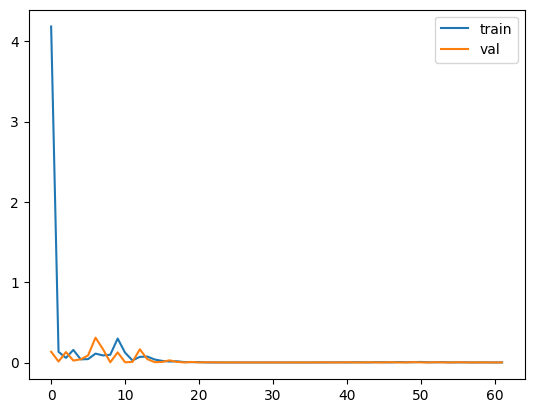

4/4 [==============================] - 0s 3ms/step
mae: 1.0799459595293315
(126,)
(126,)


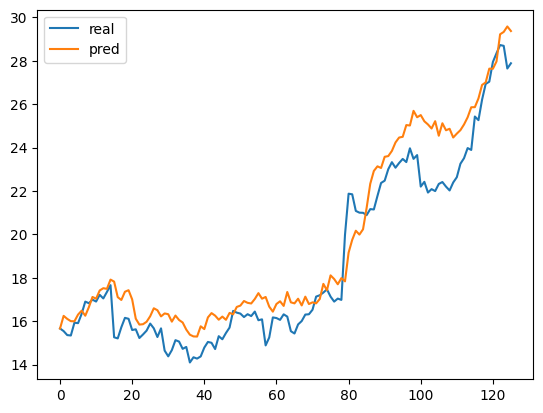

Epoch 1/1000
20/20 [==============================] - 2s 34ms/step - loss: 2.7613 - val_loss: 0.1318
Epoch 2/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.0979 - val_loss: 0.0425
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.0945 - val_loss: 0.0381
Epoch 4/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1177 - val_loss: 0.0512
Epoch 5/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3421 - val_loss: 0.0858
Epoch 6/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.0154 - val_loss: 0.0057
Epoch 7/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.0177 - val_loss: 0.0060
Epoch 8/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.0656 - val_loss: 0.0037
Epoch 9/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1153 - val_loss: 0.0024
Epoch 10/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.0255 - val_loss: 0.002

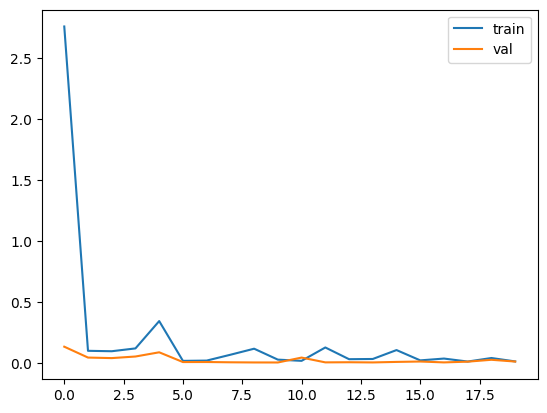

4/4 [==============================] - 0s 3ms/step
mae: 3.0160260656835165
(126,)
(126,)


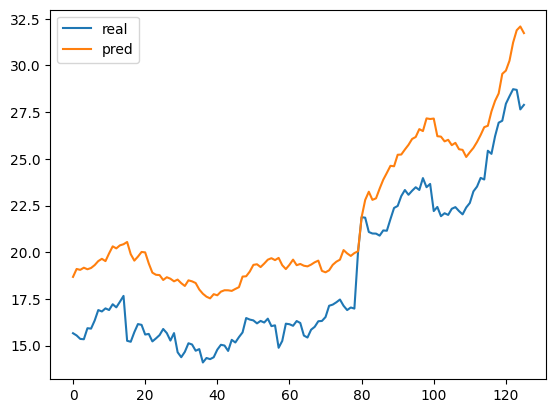

Epoch 1/1000
23/23 [==============================] - 2s 32ms/step - loss: 2.8327 - val_loss: 0.0140
Epoch 2/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.2029 - val_loss: 0.0211
Epoch 3/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.0508 - val_loss: 0.1324
Epoch 4/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.1813 - val_loss: 0.1903
Epoch 5/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.2064 - val_loss: 0.3021
Epoch 6/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0907 - val_loss: 0.0452
Epoch 7/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.1791 - val_loss: 0.0424
Epoch 8/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.0654 - val_loss: 0.0527
Epoch 9/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.1598 - val_loss: 0.0819
Epoch 10/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0377 - val_loss: 0.003

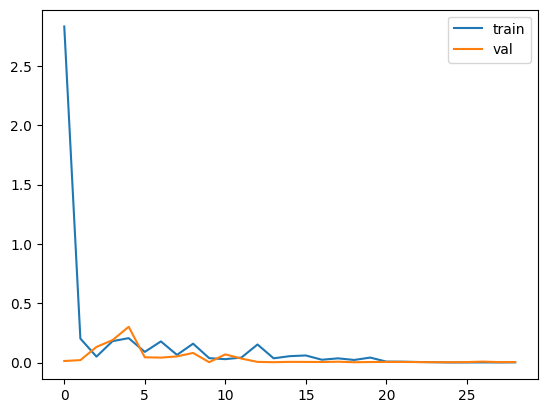

4/4 [==============================] - 0s 2ms/step
mae: 2.1616483267395985
(126,)
(126,)


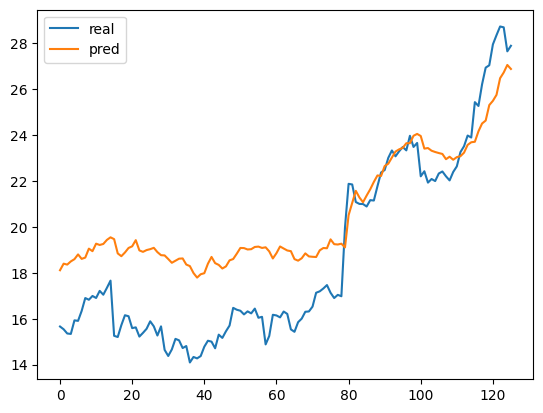

Epoch 1/1000
26/26 [==============================] - 3s 30ms/step - loss: 2.9449 - val_loss: 0.1999
Epoch 2/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.2062 - val_loss: 0.3088
Epoch 3/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.2066 - val_loss: 0.0323
Epoch 4/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.2432 - val_loss: 0.1060
Epoch 5/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.0727 - val_loss: 0.0345
Epoch 6/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.0752 - val_loss: 0.0493
Epoch 7/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.0751 - val_loss: 0.0295
Epoch 8/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.0725 - val_loss: 0.0498
Epoch 9/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.1974 - val_loss: 0.0048
Epoch 10/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.0403 - val_loss: 0.02

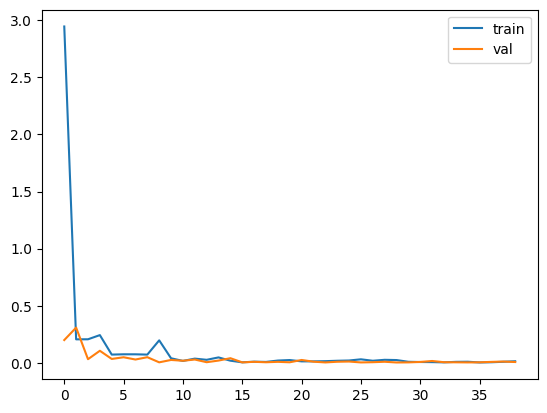

4/4 [==============================] - 0s 2ms/step
mae: 3.5198263574179993
(126,)
(126,)


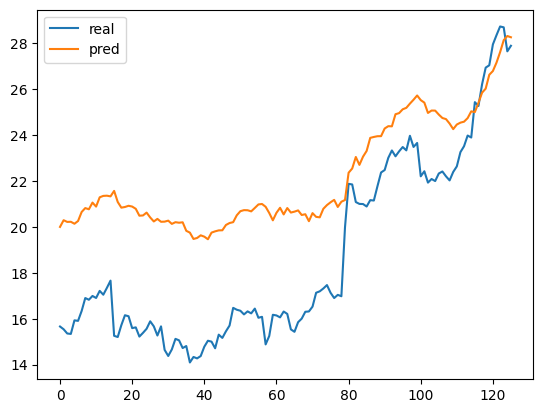

Epoch 1/1000
29/29 [==============================] - 2s 26ms/step - loss: 3.2080 - val_loss: 0.0166
Epoch 2/1000
29/29 [==============================] - 0s 9ms/step - loss: 0.1319 - val_loss: 0.0078
Epoch 3/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.0570 - val_loss: 0.0903
Epoch 4/1000
29/29 [==============================] - 0s 9ms/step - loss: 0.1813 - val_loss: 0.0756
Epoch 5/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.2985 - val_loss: 0.4749
Epoch 6/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.1268 - val_loss: 0.0221
Epoch 7/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.6876 - val_loss: 0.0116
Epoch 8/1000
29/29 [==============================] - 0s 9ms/step - loss: 0.0650 - val_loss: 0.0960
Epoch 9/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.0632 - val_loss: 0.0275
Epoch 10/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.0753 - val_loss: 0.206

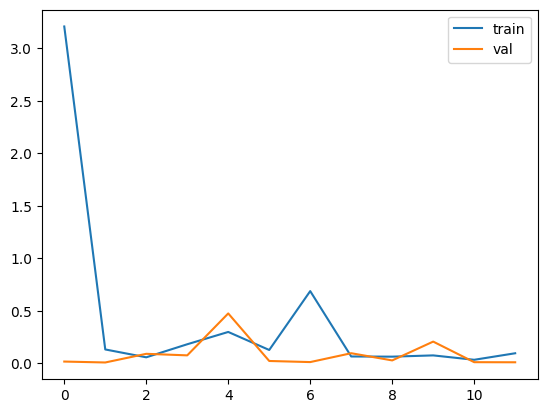

4/4 [==============================] - 0s 3ms/step
mae: 3.402358607543945
(126,)
(126,)


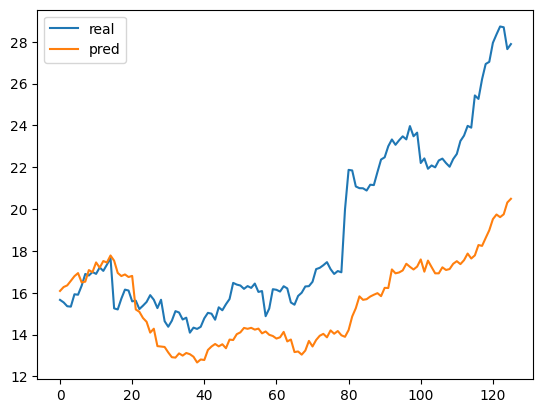

Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 2.1863

2023-11-06 20:38:17.149442: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 578.85MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 2s 25ms/step - loss: 2.1863 - val_loss: 0.0659
Epoch 2/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.1392 - val_loss: 0.0725
Epoch 3/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0516 - val_loss: 0.1298
Epoch 4/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.1199 - val_loss: 0.0311
Epoch 5/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.0913 - val_loss: 0.0632
Epoch 6/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0992 - val_loss: 0.0025
Epoch 7/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0534 - val_loss: 0.0079
Epoch 8/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0554 - val_loss: 0.0177
Epoch 9/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0578 - val_loss: 0.1429
Epoch 10/1000
32/32 [==============================] - 0s 8ms/step - loss: 0.0802 - val_loss: 0.1220
Epoch 11/10

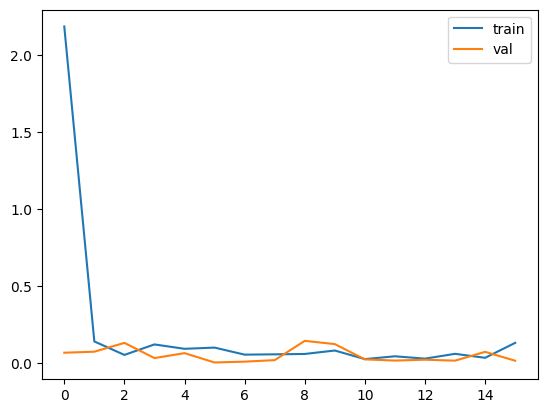

4/4 [==============================] - 0s 3ms/step
mae: 1.870727847073994
(126,)
(126,)


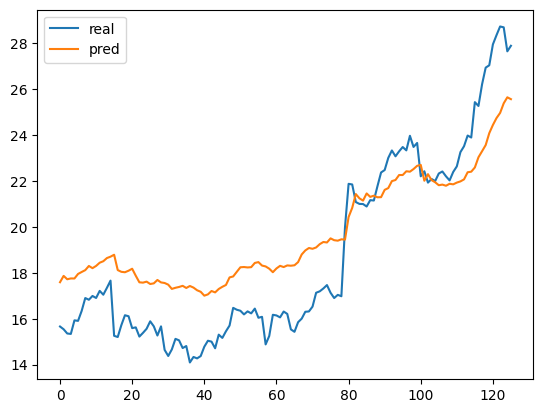

In [18]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(
     TCN(
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_size=7,
         dilations=[1, 2, 4, 8, 16],
         return_sequences=False,
        activation='relu',
            nb_filters=258,
         padding='causal',
         #dropout_rate=0.25,
         kernel_initializer='he_normal',
     )   
    )
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape
    #accuracy and other metrics
    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    #print mae for pred and y_test
    print('mae:',np.mean(np.abs(pred-y_test)))

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
